<a href="https://colab.research.google.com/github/Atfssene/FRASA/blob/main/Text%20Summarization/Regression_Model_FRASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Summarization Model

In this notebook, we will create a model for text summarization task. From previous EDA, we know they're correlation between features/columns.

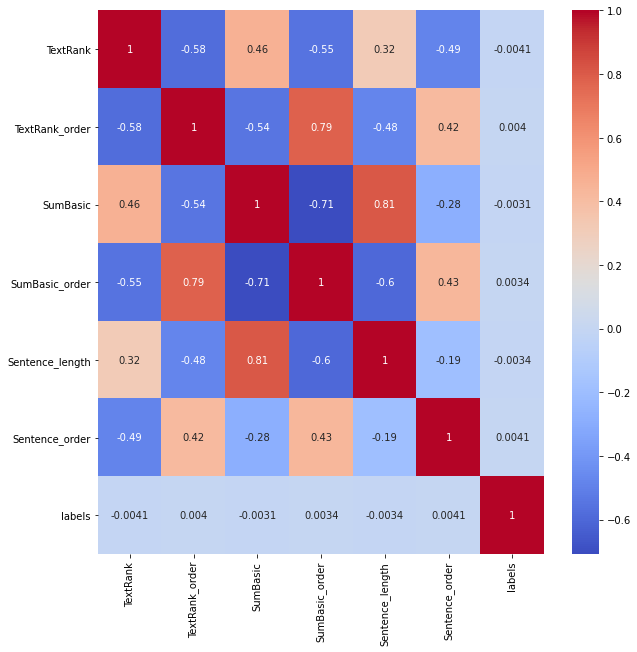

## Import library

In [15]:
# Import library
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import seaborn as sns
from tensorflow import *
from sklearn import preprocessing as sk_preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score,roc_curve

# Repository URL
url = "https://raw.githubusercontent.com/Atfssene/FRASA/main/Text%20Summarization/"

## Read data

In [2]:
list_columns = {'TextRank':eval,'TextRank_order':eval,'SumBasic':eval,'SumBasic_order':eval, 'Sentence_length':eval,'Sentence_order':eval, 'labels':eval,}

train_df = pd.read_csv(url+'/extracted_train.csv', converters=list_columns)
test_df = pd.read_csv(url+'/extracted_test.csv', converters=list_columns)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15012 entries, 0 to 15011
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   TextRank         15012 non-null  object
 1   TextRank_order   15012 non-null  object
 2   SumBasic         15012 non-null  object
 3   SumBasic_order   15012 non-null  object
 4   Sentence_length  15012 non-null  object
 5   Sentence_order   15012 non-null  object
 6   labels           15012 non-null  object
dtypes: object(7)
memory usage: 821.1+ KB


Before we flatten the data, we need to normalizing the list of TextRank and SumBasic because both are paragraph based value.

In [3]:
def normalization(list_weight):
  norm = np.array(list_weight)
  norm = norm.reshape(1,-1)
  norm = sk_preprocessing.normalize(norm)
  norm = [item for sublist in norm for item in sublist]
  return norm

normalized = ['TextRank', 'SumBasic']
for norm in normalized:
  train_df[norm] = train_df.apply(lambda row: normalization(row[norm]), axis=1)
  test_df[norm] = test_df.apply(lambda row: normalization(row[norm]), axis=1)

## Flatten data

In [4]:
flat_train = pd.DataFrame()
flat_test =  pd.DataFrame()
for column in train_df.columns:
  flat_train[column] = pd.to_numeric(train_df.explode(column, ignore_index=True)[column])
  flat_test[column] = pd.to_numeric(test_df.explode(column, ignore_index=True)[column])
flat_train

,TextRank,TextRank_order,SumBasic,SumBasic_order,Sentence_length,Sentence_order,labels
0,0.242559,7,4.162398e-01,1,15,1,0
1,0.254988,2,3.441983e-01,4,15,2,1
2,0.256001,1,3.602075e-01,2,15,3,1
3,0.220594,15,1.761015e-01,12,9,4,1
4,0.247298,4,9.605534e-02,17,7,5,0
...,...,...,...,...,...,...,...
268914,0.208422,2,3.075074e-01,3,21,24,0
268915,0.194041,15,1.590555e-01,15,9,25,0
268916,0.203506,6,2.438852e-01,5,14,26,0
268917,0.189631,16,4.771666e-02,25,6,27,0


In [5]:
flat_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TextRank,268919.0,0.228448,0.060291,1.796035e-02,0.194026,0.227848,0.263157,1.0
TextRank_order,268919.0,11.130604,8.124076,1.000000e+00,5.000000,10.000000,15.000000,76.0
SumBasic,268919.0,0.202896,0.121066,3.016877e-09,0.114266,0.188788,0.274695,1.0
SumBasic_order,268919.0,11.130604,8.124076,1.000000e+00,5.000000,10.000000,15.000000,76.0
Sentence_length,268919.0,10.995839,6.127034,0.000000e+00,7.000000,10.000000,14.000000,187.0
Sentence_order,268919.0,11.130604,8.124076,1.000000e+00,5.000000,10.000000,15.000000,76.0
labels,268919.0,0.186844,0.389787,0.000000e+00,0.000000,0.000000,0.000000,1.0


No empty values. Great!

Let's see flatten data in a graph

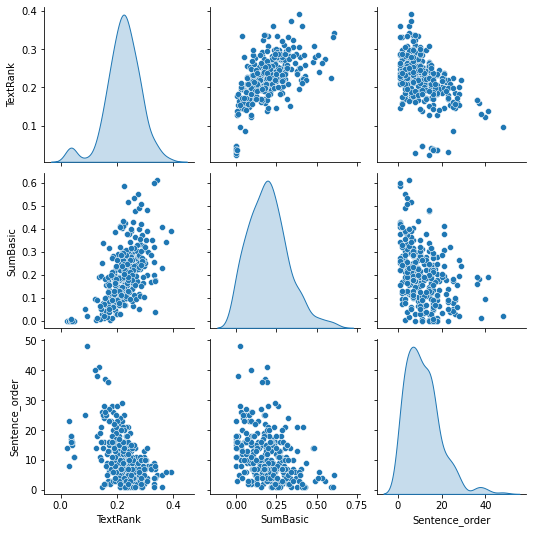

In [6]:
sns.pairplot(flat_train.sample(300)[['TextRank', 'SumBasic', 'Sentence_order']], diag_kind='kde')

We can see outliers here, let's remove them.

We will cutoff the 

In [7]:
data = flat_train['TextRank']
data_mean, data_std = data.mean(axis=0), data.std(axis=0)
# This is use 4x standar deviation to identify outliers
cut_off = data_std * 4
lower, upper = data_mean - cut_off, data_mean + cut_off

outliers = [x for x in data if x < lower or x > upper]

print(lower, upper)
flat_train = flat_train[~flat_train.TextRank.isin(outliers)]

-0.012714398480096173 0.46961068250983484


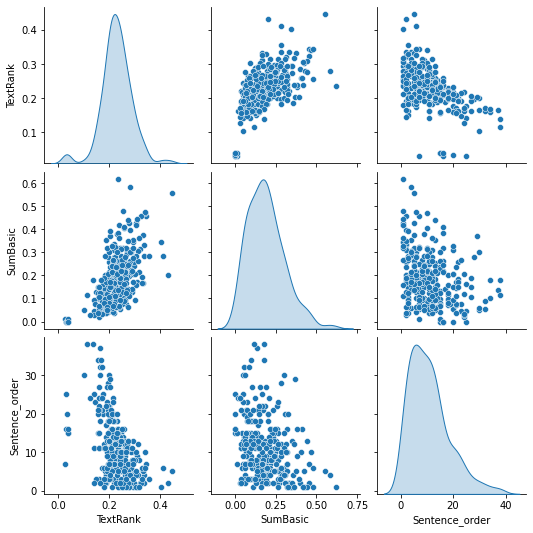

In [8]:
sns.pairplot(flat_train.sample(300)[['TextRank', 'SumBasic', 'Sentence_order']], diag_kind='kde')

## Split features and target

In [153]:
target = "TextRank"
features=['SumBasic', 'SumBasic_order', 'Sentence_length', 'Sentence_order']
x_train = flat_train[features].copy()
x_test = flat_test[features].copy()

y_train = flat_train[target].copy()
y_test = flat_test[target].copy()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((268658, 4), (66659, 4), (268658,), (66659,))

# Create Model #1

## Normalization Layer

Function to build and compile model with normalization layer

In [10]:
def create_model(x_train):
  norm_layer = preprocessing.Normalization()
  norm_layer.adapt(np.array(x_train))
  model = keras.Sequential([
      norm_layer,
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.0001))
  return model

Function to plotting loss

In [11]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

## DNN Layer

In [17]:
model = create_model(x_train)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 17,290
Trainable params: 17,281
Non-trainable params: 9
_________________________________________________________________


## Callback

In [158]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5, mode='min')

## Train layer

In [159]:
history = model.fit(
    x_train,
    y_train,
    validation_split=0.001,
    verbose=0,
    epochs=100,
    callbacks = [callbacks]
    )

Epoch 00008: early stopping


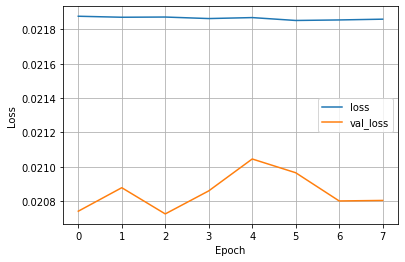

In [160]:
plot_loss(history)

## Evaluate result #1

Save the result to compare later

In [86]:
evaluate_result = {}

In [90]:
evaluate_result['TR: 4 features'] = model.evaluate(x_test, y_test, verbose=1)

2084/2084 [==============================] - 2s 1ms/step - loss: 0.0222


In [155]:
test_predictions = model.predict(x_test).flatten()

for i, t in enumerate(y_test[:10]):
  print(test_predictions[i], t)

0.27735668 0.25559530567818917
0.26452518 0.24572682221837625
0.2332233 0.24018587818720966
0.2562448 0.2468131652371983
0.23865023 0.2436909275562206
0.22261947 0.23186550023376296
0.23476945 0.23259516712618628
0.20069304 0.2219968816220938
0.20989433 0.2374203618123999
0.2358111 0.22470100601433482


In [92]:
pd.DataFrame(evaluate_result, index=['Mean Absolute Error']).T

,Mean Absolute Error
TR: 4 features,0.02217


# Create Model #2

Let's try again but with more selected features.

In [93]:
target = "TextRank"
features=['SumBasic', 'Sentence_length']
x_train = flat_train[features].copy()
x_test = flat_test[features].copy()

y_train = flat_train[target].copy()
y_test = flat_test[target].copy()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((268658, 2), (66659, 2), (268658,), (66659,))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 2)                 5         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 17,030
Trainable params: 17,025
Non-trainable params: 5
_________________________________________________________________
Epoch 1/100
8312/8312 - 9s - loss: 0.0356 - val_loss: 0.0340
Epoch 2/100
8312/8312 - 8s - loss: 0.0328 - val_loss: 0.0336
Epoch 3/100
8312/8312 - 8s - loss: 0.0327 - val_loss: 0.0340
Epoch 4/100
8312/8312 - 8s - loss: 0.0326 - val_loss: 0.0344
Epoc

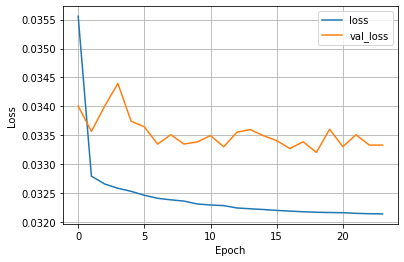

In [83]:
second_model = create_model(x_train)
second_model.summary()

history = second_model.fit(
    x_train,
    y_train,
    validation_split=0.001,
    verbose=2,
    epochs=100,
    callbacks = [callbacks])

plot_loss(history)

## Evaluate result #2

Save the result to compare later

In [94]:
evaluate_result['TR: 2 features'] = second_model.evaluate(x_test, y_test, verbose=1)

2084/2084 [==============================] - 2s 979us/step - loss: 0.0321


In [95]:
test_predictions = second_model.predict(x_test).flatten()

for i, t in enumerate(y_test[:10]):
  print(test_predictions[i], t)

0.255864 0.25559530567818917
0.26713848 0.24572682221837625
0.22336493 0.24018587818720966
0.257727 0.2468131652371983
0.2344043 0.2436909275562206
0.22710802 0.23186550023376296
0.23007314 0.23259516712618628
0.22179179 0.2219968816220938
0.2146813 0.2374203618123999
0.21655321 0.22470100601433482


In [96]:
pd.DataFrame(evaluate_result, index=['Mean Absolute Error']).T

,Mean Absolute Error
TR: 4 features,0.022170
TR: 2 features,0.032118


# Create Model #3

In [97]:
target = "TextRank"
features=['SumBasic']
x_train = flat_train[features].copy()
x_test = flat_test[features].copy()

y_train = flat_train[target].copy()
y_test = flat_test[target].copy()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((268658, 1), (66659, 1), (268658,), (66659,))

Epoch 1/100
8388/8388 - 9s - loss: 0.0360 - val_loss: 0.0302
Epoch 2/100
8388/8388 - 8s - loss: 0.0330 - val_loss: 0.0294
Epoch 3/100
8388/8388 - 8s - loss: 0.0328 - val_loss: 0.0292
Epoch 4/100
8388/8388 - 8s - loss: 0.0328 - val_loss: 0.0293
Epoch 5/100
8388/8388 - 8s - loss: 0.0327 - val_loss: 0.0300
Epoch 6/100
8388/8388 - 8s - loss: 0.0327 - val_loss: 0.0293
Epoch 7/100
8388/8388 - 8s - loss: 0.0327 - val_loss: 0.0294
Epoch 8/100
8388/8388 - 8s - loss: 0.0327 - val_loss: 0.0293
Epoch 00008: early stopping
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       


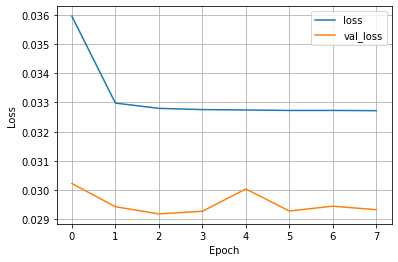

In [98]:
third_norm = preprocessing.Normalization()
third_norm.adapt(np.array(x_train))

# Remove the normalized layer because we have did in early this notebook
third_model = keras.Sequential([
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(1)
  ])

third_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.0001))

history = third_model.fit(
    x_train,
    y_train,
    validation_split=0.001,
    verbose=2,
    epochs=100,
    callbacks = [callbacks])
third_model.summary() 
plot_loss(history)

## Evaluate result #3

Save the result to compare later

In [99]:
evaluate_result['TR:1 features'] = third_model.evaluate(x_test, y_test, verbose=1)

2084/2084 [==============================] - 2s 980us/step - loss: 0.0326


In [100]:
test_predictions = third_model.predict(x_test).flatten()

for i, t in enumerate(y_test[:10]):
  print(test_predictions[i], t)

0.27054253 0.25559530567818917
0.27054253 0.24572682221837625
0.22755456 0.24018587818720966
0.25170016 0.2468131652371983
0.24387029 0.2436909275562206
0.22551508 0.23186550023376296
0.22551508 0.23259516712618628
0.2152444 0.2219968816220938
0.21941468 0.2374203618123999
0.22755456 0.22470100601433482


In [101]:
pd.DataFrame(evaluate_result, index=['Mean Absolute Error']).T

,Mean Absolute Error
TR: 4 features,0.022170
TR: 2 features,0.032118
TR:1 features,0.032572


# Create Model #4

In [144]:
target = "TextRank_order"
features=['SumBasic', 'SumBasic_order', 'Sentence_length', 'Sentence_order']
x_train = flat_train[features].copy()
x_test = flat_test[features].copy()

y_train = flat_train[target].copy()
y_test = flat_test[target].copy()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((268658, 4), (66659, 4), (268658,), (66659,))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               640       
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 17,290
Trainable params: 17,281
Non-trainable params: 9
_________________________________________________________________
Epoch 1/100
8312/8312 - 10s - loss: 3.7307 - val_loss: 3.8437
Epoch 2/100
8312/8312 - 9s - loss: 3.3995 - val_loss: 3.8293
Epoch 3/100
8312/8312 - 9s - loss: 3.3930 - val_loss: 3.8238
Epoch 4/100
8312/8312 - 9s - loss: 3.3888 - val_loss: 3.8167
Epo

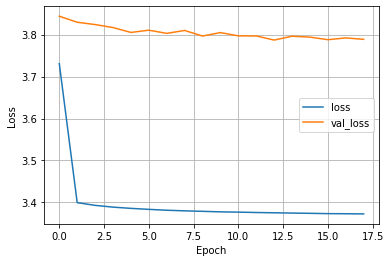

In [103]:
model4th = create_model(x_train)
model4th.summary()

history = model4th.fit(
    x_train,
    y_train,
    validation_split=0.01,
    verbose=2,
    epochs=100,
    callbacks = [callbacks])

plot_loss(history)

## Evaluate result #4

Save the result to compare later

In [104]:
evaluate_result['TR Order: 4 features'] = model4th.evaluate(x_test, y_test, verbose=1)

2084/2084 [==============================] - 2s 980us/step - loss: 3.2800


In [107]:
test_predictions = model4th.predict(x_test).flatten()

for i, t in enumerate(y_test[:10]):
  print(test_predictions[i], t, round(test_predictions[i]))

4.034398 1 4
3.986924 3 4
9.294143 8 9
5.313383 2 5
5.646542 6 6
10.277895 12 10
9.754843 11 10
16.001781 16 16
11.374086 10 11
8.20742 14 8


In [108]:
pd.DataFrame(evaluate_result, index=['Mean Absolute Error']).T

,Mean Absolute Error
TR: 4 features,0.022170
TR: 2 features,0.032118
TR:1 features,0.032572
TR Order: 4 features,3.280046


In [156]:
# y_train['pred'] = 1
# y_train.drop(['pred'])

y_order['TextRank pred'] = test_predictions
# y_order = pd.DataFrame(y_test)
y_order.tail()

,TextRank_order,pred,pred_2,TextRank,TextRank pred
66654,10,15.858721,16.0,0.205191,0.185489
66655,23,22.028240,22.0,0.176446,0.175611
66656,21,25.784842,26.0,0.179090,0.146243
66657,26,24.800163,25.0,0.147998,0.159123
66658,28,29.179722,29.0,0.028671,0.018731


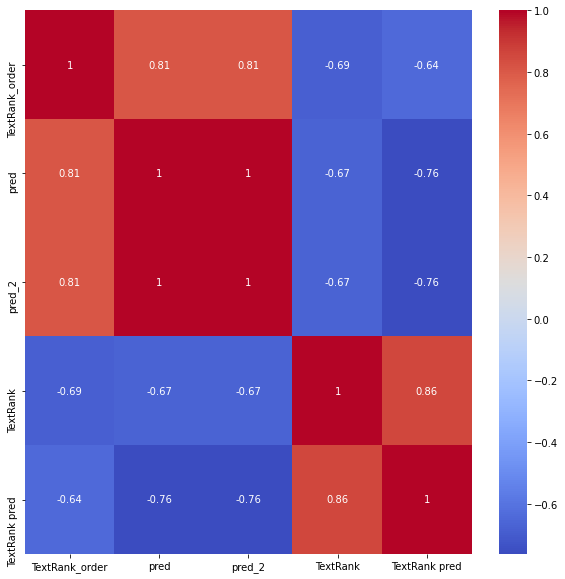

In [157]:
plt.figure(figsize=(10,10))
_ = sns.heatmap(y_order.corr(), cmap='coolwarm', annot=True)

From this plot, we know predict to TextRank value is better that TextRank sentences order.

# Save

It seems clear that 4 features is better, far better. So, we save the models and continue to the deployment.

In [ ]:
model.save('frasa_model')
model.save('frasa_model.h5')

In [ ]:
reloaded = tf.keras.models.load_model('frasa_model')

evaluate_result['reloaded'] = reloaded.evaluate(
    x_test, y_test, verbose=0)

In [ ]:
pd.DataFrame(evaluate_result, index=['Mean Absolute Error']).T

In [ ]:
reloaded.summary()

In [ ]:
test_predictions = reloaded.predict(x_test).flatten()
for t in range(1,10):
  print(round(test_predictions[t], ndigits=5), round(y_test[t],ndigits=5))